# ECMA 31330 Final Project
### Abby Beckler, Miles Brown

In [128]:
# imports
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## Load Data + Use KNN to Impute Missing Values

In [129]:
# set seed to ensure reproducibility
np.random.seed(25)

# load the data
ANES = pd.read_csv('data/ANES.csv')

# remove rows with missing 'pocket', 'retro', and 'trumpft' values
ANES = ANES.dropna(subset=['pocket', 'retro', 'trumpft'])

# impute using k-nearest neighbors imputer
imputer = KNNImputer(n_neighbors=5)
ANES = pd.DataFrame(imputer.fit_transform(ANES), columns=ANES.columns)

# add relevant columns 'pocketEval' and 'econEval'
ANES['pocketEval'] = (ANES['pocket'] - 3) * (-1/2)
ANES['econEval'] = (ANES['retro'] - 3) * (-1/2)

## Perform Initial OLS Regressions (same as K&K)

In [130]:
# isolate the independent and dependent variables
X_pocket = ANES[['pocketEval']]
X_econ = ANES[['econEval']]
X_ols = ANES[['pocketEval', 'econEval']]
y = ANES['trumpft']

# run the OLS regression for the pocket and econ evaluations
X_ols = sm.add_constant(X_ols)
model_ols = sm.OLS(y, X_ols).fit()
print(model_ols.summary())

# export the results to a .tex file
with open('outputs/ols_results.tex', 'w') as tf:
    tf.write(model_ols.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     1939.
Date:                Fri, 14 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:50:17   Log-Likelihood:                -39332.
No. Observations:                7998   AIC:                         7.867e+04
Df Residuals:                    7995   BIC:                         7.869e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.5503      0.426    123.293      0.0

## More Complex OLS Regressions (+ Covariates)

In [131]:
# create list of covariate columns
covariates = ANES.columns.tolist()
removed = ['trumpft', 'trumpft_post', 'pocket', 'retro', 'pocketEval', 'econEval', 'votepres',
           'bidenft', 'bidenft_post', 'pid_lean', 'pid_strong', 'pid3', 'pid7']
for col in removed:
    covariates.remove(col)

# run the OLS regression for the simultaneous pocket and econ evaluations with covariates
regression_cols = ['pocketEval', 'econEval'] + covariates
X_ols_covs = ANES[regression_cols]
X_ols_covs = sm.add_constant(X_ols_covs)
model_ols_covs = sm.OLS(y, X_ols_covs).fit()
print(model_ols_covs.summary())

# export the results to a .tex file
with open('outputs/ols_covs_results.tex', 'w') as tf:
    tf.write(model_ols_covs.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1153.
Date:                Fri, 14 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:50:17   Log-Likelihood:                -32617.
No. Observations:                7998   AIC:                         6.533e+04
Df Residuals:                    7949   BIC:                         6.567e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   35.5316 

## Train/Test Split

In [ ]:
# train test split the pocket and econ + covariate data
X_pocket_cov_train, X_pocket_cov_test, y_train_pocket, y_test_pocket = train_test_split(X_pocket_cov, y, test_size=0.2, random_state=25)
X_econ_cov_train, X_econ_cov_test, y_train_econ, y_test_econ = train_test_split(X_econ_cov, y, test_size=0.2, random_state=25)


# standardize the data
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
X_pocket_cov_train = scaler.fit_transform(X_pocket_cov_train)
X_pocket_cov_test = scaler.transform(X_pocket_cov_test)
X_econ_cov_train = scaler.fit_transform(X_econ_cov_train)
X_econ_cov_test = scaler.transform(X_econ_cov_test)

X_pocket_cov_train = pd.DataFrame(X_pocket_cov_train, columns=X_pocket_cov.columns)
X_pocket_cov_test = pd.DataFrame(X_pocket_cov_test, columns=X_pocket_cov.columns)
X_econ_cov_train = pd.DataFrame(X_econ_cov_train, columns=X_econ_cov.columns)
X_econ_cov_test = pd.DataFrame(X_econ_cov_test, columns=X_econ_cov.columns)

print(X_pocket_cov_train.head())
print("now econ")
print(X_econ_cov_train.head())
#scaler_y = StandardScaler()
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_pocket = scaler_y.fit_transform(y_train_pocket.values.reshape(-1, 1))
y_test_pocket = scaler_y.transform(y_test_pocket.values.reshape(-1, 1))
y_train_econ = scaler_y.fit_transform(y_train_econ.values.reshape(-1, 1))
y_test_econ = scaler_y.transform(y_test_econ.values.reshape(-1, 1))

y_train_pocket = pd.DataFrame(y_train_pocket, columns=['trumpft'])
y_test_pocket = pd.DataFrame(y_test_pocket, columns=['trumpft'])
y_train_econ = pd.DataFrame(y_train_econ, columns=['trumpft'])
y_test_econ = pd.DataFrame(y_test_econ, columns=['trumpft'])
#'''


   const  pocketEval  mode  prepost   sp_serv  sp_serv_biden  sp_serv_trump  \
0   -1.0         1.0   1.0      1.0  0.066667       1.000000       0.000000   
1   -1.0        -1.0   1.0     -1.0  0.600000       1.000000      -1.000000   
2   -1.0         0.0   1.0      1.0 -0.333333       1.000000      -0.666667   
3   -1.0         0.5   1.0      1.0  1.000000      -0.333333      -1.000000   
4   -1.0         1.0   1.0      1.0  0.333333       0.000000      -0.666667   

   jobs_living  jobs_living_biden  jobs_living_trump  ...  immigration  \
0     0.000000           0.000000           0.000000  ...    -1.000000   
1     0.666667          -0.333333          -1.000000  ...     1.000000   
2     0.000000          -1.000000           0.666667  ...     0.333333   
3     0.000000           0.000000           1.000000  ...     1.000000   
4    -0.666667           0.000000           0.666667  ...     1.000000   

   gun_diff  offensive_language  harassment  no_children  arrested  feminist  \


## LASSO Regression

In [133]:

# fit LASSO models
lasso_pocket = Lasso(alpha=0.2, random_state=25)
lasso_pocket.fit(X_pocket_cov_train, y_train_pocket)

lasso_econ = Lasso(alpha=0.2, random_state=25)
lasso_econ.fit(X_econ_cov_train, y_train_econ)

# compute test accuracy for the models
print('Test accuracy for pocketEval model:', lasso_pocket.score(X_pocket_cov_test, y_test_pocket))
print('Test accuracy for econEval model:', lasso_econ.score(X_econ_cov_test, y_test_econ))

# compare the selected features for the two models
print('Selected features for pocketEval model:')
print(X_pocket_cov.columns[lasso_pocket.coef_ != 0])
print('Number of selected features:', sum(lasso_pocket.coef_ != 0))

print('Selected features for econEval model:')
print(X_econ_cov.columns[lasso_econ.coef_ != 0])
print('Number of selected features:', sum(lasso_econ.coef_ != 0))

Test accuracy for pocketEval model: 0.7598249006326835
Test accuracy for econEval model: 0.7598249749106758
Selected features for pocketEval model:
Index(['covid_approval', 'immigration'], dtype='object')
Number of selected features: 2
Selected features for econEval model:
Index(['covid_approval', 'immigration'], dtype='object')
Number of selected features: 2


## Neural Network (?)

In [134]:
# train a neural network on pocketEval model
class ANESDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ANESNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANESNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = X_pocket_cov_train.shape[1]
hidden_dim = 100
output_dim = 1



def train_model(X_train_model, y_train_model, X_test_model, y_test_model, input_dim, hidden_dim, output_dim, n_epochs=50):
    anes_net = ANESNet(input_dim, hidden_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(anes_net.parameters(), lr=0.001)

    anes_train = ANESDataset(X_train_model, y_train_model)
    anes_test = ANESDataset(X_test_model, y_test_model)

    train_loader = DataLoader(anes_train, batch_size=64, shuffle=True)
    test_loader = DataLoader(anes_test, batch_size=64, shuffle=False)


    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        anes_net.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = anes_net(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        anes_net.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = anes_net(X_batch)
                loss = criterion(output, y_batch)
                test_loss += loss.item()
            print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Test Loss: {test_loss / len(test_loader)}')
            test_losses.append(test_loss / len(test_loader))
    return anes_net, test_loader

anes_net_pocket, anes_loader = train_model(X_pocket_cov_train, y_train_pocket, X_pocket_cov_test, y_test_pocket, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.36593663796782494, Test Loss: 0.10001464784145356
Epoch 2, Train Loss: 0.1842947681993246, Test Loss: 0.08996574163436889
Epoch 3, Train Loss: 0.14501718148589135, Test Loss: 0.08542645171284675
Epoch 4, Train Loss: 0.132281311750412, Test Loss: 0.08503642663359642
Epoch 5, Train Loss: 0.12725434370338917, Test Loss: 0.08492849305272103
Epoch 6, Train Loss: 0.12379619039595127, Test Loss: 0.08399122849106788
Epoch 7, Train Loss: 0.11894869446754455, Test Loss: 0.08498134508728981
Epoch 8, Train Loss: 0.1193293397128582, Test Loss: 0.08386074781417846
Epoch 9, Train Loss: 0.1158386716246605, Test Loss: 0.08301637187600136
Epoch 10, Train Loss: 0.11959499645978212, Test Loss: 0.08808642596006394
Epoch 11, Train Loss: 0.11237325072288513, Test Loss: 0.08579444319009781
Epoch 12, Train Loss: 0.1113365613669157, Test Loss: 0.08168346434831619
Epoch 13, Train Loss: 0.1128555403649807, Test Loss: 0.08116506263613701
Epoch 14, Train Loss: 0.11192374758422374, Test Loss: 

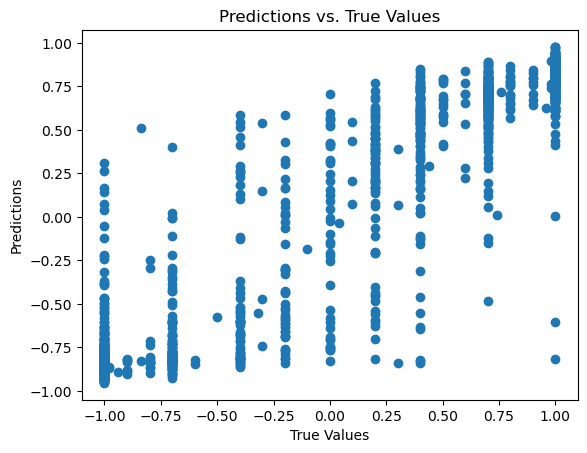

In [135]:
anes_net_pocket.eval()
pocket_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_pocket(X_batch)
        pocket_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_pocket, pocket_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')
plt.show()


In [136]:
# train a neural network on econEval model
input_dim = X_econ_cov_train.shape[1]
anes_net_econ, anes_loader = train_model(X_econ_cov_train, y_train_econ, X_econ_cov_test, y_test_econ, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.3836562855541706, Test Loss: 0.10783642888069153
Epoch 2, Train Loss: 0.1887717428803444, Test Loss: 0.0972711780667305
Epoch 3, Train Loss: 0.15210762836039066, Test Loss: 0.0854552611708641
Epoch 4, Train Loss: 0.13300313375890255, Test Loss: 0.0833703926205635
Epoch 5, Train Loss: 0.1303735288977623, Test Loss: 0.08599131792783737
Epoch 6, Train Loss: 0.12476773779839277, Test Loss: 0.08512328937649727
Epoch 7, Train Loss: 0.1204043498262763, Test Loss: 0.08586966782808304
Epoch 8, Train Loss: 0.12372257649898528, Test Loss: 0.08298837676644326
Epoch 9, Train Loss: 0.11471765927970409, Test Loss: 0.08233359590172767
Epoch 10, Train Loss: 0.11513378843665123, Test Loss: 0.08266286447644233
Epoch 11, Train Loss: 0.11285767011344433, Test Loss: 0.08431855887174607
Epoch 12, Train Loss: 0.11764588341116905, Test Loss: 0.08506596654653549
Epoch 13, Train Loss: 0.11057177901268006, Test Loss: 0.08013625174760819
Epoch 14, Train Loss: 0.10964325737208128, Test Loss: 

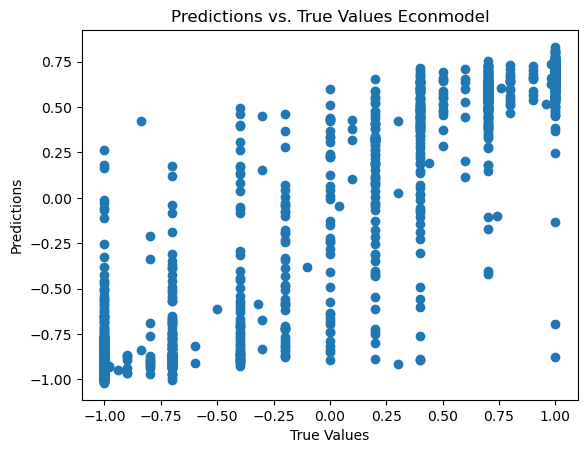

R^2 value for pocketEval model: 0.878801331356377
R^2 value for econEval model: 0.8694968173978082


In [137]:
anes_net_econ.eval()
econ_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_econ(X_batch)
        econ_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_econ, econ_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values Econmodel')
plt.show()

from sklearn.metrics import r2_score
print('R^2 value for pocketEval model:', r2_score(y_test_pocket, pocket_predictions))
print('R^2 value for econEval model:', r2_score(y_test_econ, econ_predictions))

## Random Forest

In [138]:
# run a Random Forest on pocketEval test data and covariates
rf_pocket = RandomForestRegressor(n_estimators=500, random_state=25)
rf_pocket.fit(X_pocket_cov_train, y_train_pocket)

feature_importance_pocket = pd.DataFrame({
    "Feature": X_pocket_cov.columns,
    "Importance": rf_pocket.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_pocket.head(10)

# get random forest prediction accuracy on pocket test
rf_pocket.score(X_pocket_cov_test, y_test_pocket)
print('Random Forest accuracy on pocketEval model:', rf_pocket.score(X_pocket_cov_test, y_test_pocket))

c:\Users\miles\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest accuracy on pocketEval model: 0.8855357833615936


In [139]:
# run a Random Forest on econEval and covariates
rf_econ = RandomForestRegressor(n_estimators=500, random_state=25)
rf_econ.fit(X_econ_cov_train, y_train_econ)

feature_importance_econ = pd.DataFrame({
    "Feature": X_econ_cov.columns,
    "Importance": rf_econ.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_econ.head(10)

# get random forest prediction accuracy on econ test
rf_econ.score(X_econ_cov_test, y_test_econ)
print('Random Forest accuracy on econEval model:', rf_econ.score(X_econ_cov_test, y_test_econ))

c:\Users\miles\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest accuracy on econEval model: 0.8852674563206064
